# Configuring Workspace

In [1]:
#from google.colab import drive
#drive.mount("/content/drive")

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow import keras
from functools import partial
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay

path = 'C:/Users/Dom/Desktop/life/post-grad/phong paper 1/code/'

## Create Datasets

In [2]:
#train_dir = "/content/drive/MyDrive/archive/seg_test/seg_test"
#val_dir = "/content/drive/MyDrive/archive/seg_test/seg_test2/seg_test2"
train_dir = "D:/Users/Dom/Desktop/College/coursework/4th year/J-Term 2022/Data Science Project 2/archive/seg_test/seg_test"
val_dir = "D:/Users/Dom/Desktop/College/coursework/4th year/J-Term 2022/Data Science Project 2/archive/seg_test/seg_test2"


label_dict = {0:"buildings", 1:"forest", 2:"glacier", 3:"mountain",
          4:"sea", 5:"street"}
label_lst = ["buildings", "forest", "glacier", "mountain", "sea", "street"]

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    class_names=label_lst,
    image_size=(150, 150),
    batch_size=32,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    labels="inferred",
    class_names=label_lst,
    image_size=(150, 150),
    batch_size=32,
)

# Configuring data for performance
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

Found 3000 files belonging to 6 classes.
Found 600 files belonging to 6 classes.


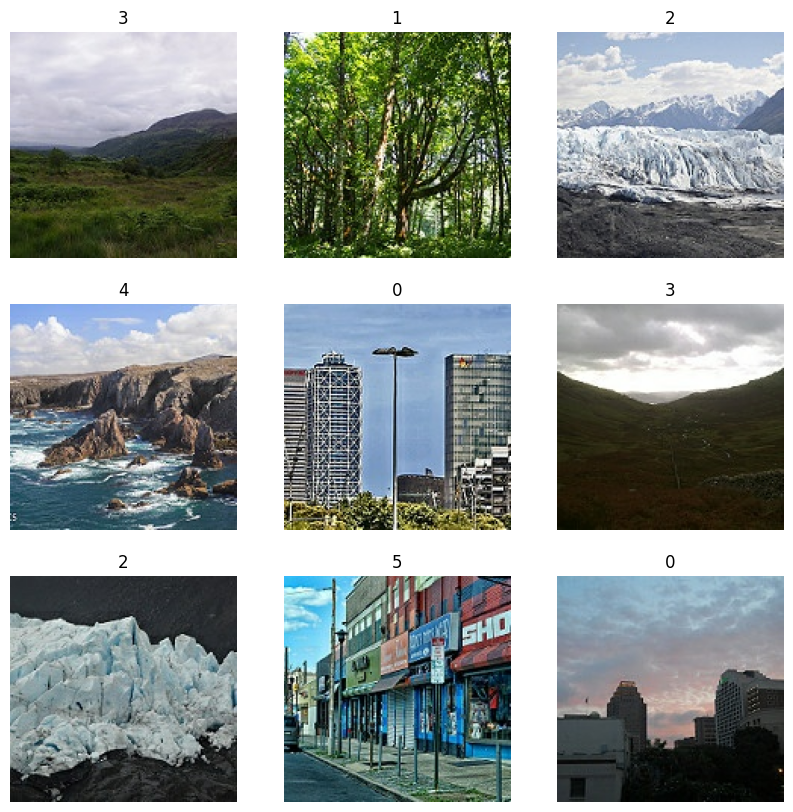

In [3]:
# Viewing data
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [4]:
#train_data = ImageDataBunch.from_folder('/content/drive/MyDrive/archive', 
#                                        train=train_dir, valid=val_dir,
#                                        ds_tfms=get_transforms(), size=150,
#                                        num_workers=2).normalize(imagenet_stats)

#data.show_batch(rows=3, figsize=(7,6),recompute_scale_factor=True)


# Simple CNN from Textbook

## Model Creation

In [5]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=5, input_shape=[150, 150, 3]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=10, activation='softmax')
])

## Master Run Script

In [6]:
def master_run(epochs = 2, model_name="Simple_CNN"):
    image_size = (180, 180)
    batch_size = 32
  
    # initialize model
    os.chdir(path)

    callbacks = [
        keras.callbacks.ModelCheckpoint(model_name + f'_at_{epochs}.h5')
    ]
  
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    model.fit(
        x=train_ds, 
        y=None,
        epochs=epochs, 
        callbacks=callbacks, 
        validation_data=val_ds,
    )

## Run Code


In [7]:
master_run(epochs=20)

Epoch 1/20
94/94 [==============================] - 1005s 11s/step - loss: 6.1790 - accuracy: 0.2753 - val_loss: 1.3487 - val_accuracy: 0.4517
Epoch 2/20
94/94 [==============================] - 1075s 11s/step - loss: 1.4035 - accuracy: 0.4647 - val_loss: 1.0776 - val_accuracy: 0.5800
Epoch 3/20
94/94 [==============================] - 1105s 12s/step - loss: 1.1672 - accuracy: 0.5363 - val_loss: 1.0243 - val_accuracy: 0.5900
Epoch 4/20
94/94 [==============================] - 1024s 11s/step - loss: 1.0285 - accuracy: 0.5947 - val_loss: 0.9990 - val_accuracy: 0.5983
Epoch 5/20
94/94 [==============================] - 979s 10s/step - loss: 0.9798 - accuracy: 0.6210 - val_loss: 0.9923 - val_accuracy: 0.6117
Epoch 6/20
94/94 [==============================] - 1009s 11s/step - loss: 0.8597 - accuracy: 0.6670 - val_loss: 1.0441 - val_accuracy: 0.6333
Epoch 7/20
94/94 [==============================] - 1031s 11s/step - loss: 0.8027 - accuracy: 0.7110 - val_loss: 1.0213 - val_accuracy: 0.6383


## Model Test

1/1 [==============================] - 3s 3s/step


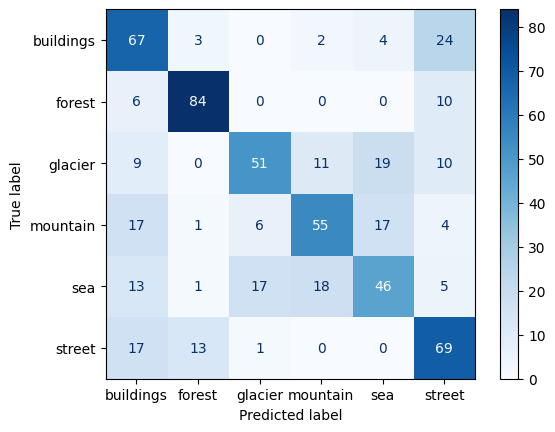

In [8]:
# Dictionary to convert labels from int to str
label_dict = {0:"buildings", 1:"forest", 2:"glacier", 3:"mountain",
          4:"sea", 5:"street"}

# Load the last model
last_model = keras.models.load_model(f"{path}Simple_CNN_at_20.h5")

# Generate predictions and true values
preds_lst = []
true_lst = []
for image in val_ds:
    prediction = np.argmax(last_model.predict(image[0]), axis=-1)
    prediction = np.array(prediction).tolist()
    preds_lst = preds_lst + prediction
    
    true_label = image[1]
    true_label = np.array(true_label).tolist()
    true_lst = true_lst + true_label


# Mapping labels
preds_lst = list(map(label_dict.get, preds_lst))
true_lst = list(map(label_dict.get, true_lst))


# Generate confusion matrix
ConfusionMatrixDisplay.from_predictions(true_lst, preds_lst, cmap="Blues")
plt.show()

In [9]:
# Calculate accuracy of Model 1
total_test = len(true_lst)
corr_preds = 0
for index, value in enumerate(true_lst):
    if value == preds_lst[index]:
        corr_preds += 1
        
acc = corr_preds / total_test * 100
print(f"Model Accuracy : {round(acc,2)}%")

Model Accuracy : 62.0%


# Simple CNN with Depth Pooling

## Model Creation

In [10]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, 
                        activation='relu', padding="SAME")

Depth_Pool1 = keras.layers.Lambda(
    lambda X: tf.math.reduce_max(X, 
                            axis=[3], 
                            keepdims=True))

Depth_Pool2 = keras.layers.Lambda(
    lambda X: tf.math.reduce_max(X, 
                            axis=[3], 
                            keepdims=True))

model2 = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=5, input_shape=[150, 150, 3]),
    keras.layers.MaxPooling2D(pool_size=2, padding="SAME"),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2, padding="SAME"),
    Depth_Pool1,

    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2, padding="SAME"),
    Depth_Pool2,

    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=10, activation='softmax')
])

## Master Run Script

In [11]:
def master_run2(epochs = 2, model_name="Simple_CNN_W_DepthP"):
    image_size = (180, 180)
    batch_size = 32
  
    # initialize model
    os.chdir(path)

    callbacks = [
        keras.callbacks.ModelCheckpoint(model_name + f'_at_{epochs}.h5')
    ]
  
    model2.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    model2.fit(
        x=train_ds, 
        y=None,
        epochs=epochs, 
        callbacks=callbacks, 
        validation_data=val_ds,
    )

## Run Code

In [12]:
master_run2(epochs=20)

Epoch 1/20
94/94 [==============================] - 882s 9s/step - loss: 2.2357 - accuracy: 0.1740 - val_loss: 1.4205 - val_accuracy: 0.4150
Epoch 2/20
94/94 [==============================] - 877s 9s/step - loss: 1.3643 - accuracy: 0.4243 - val_loss: 1.0786 - val_accuracy: 0.5600
Epoch 3/20
94/94 [==============================] - 864s 9s/step - loss: 1.2079 - accuracy: 0.5037 - val_loss: 1.0708 - val_accuracy: 0.5850
Epoch 4/20
94/94 [==============================] - 862s 9s/step - loss: 1.1099 - accuracy: 0.5483 - val_loss: 0.9182 - val_accuracy: 0.6317
Epoch 5/20
94/94 [==============================] - 855s 9s/step - loss: 1.0401 - accuracy: 0.5673 - val_loss: 0.9914 - val_accuracy: 0.6200
Epoch 6/20
94/94 [==============================] - 851s 9s/step - loss: 0.9947 - accuracy: 0.5947 - val_loss: 0.8984 - val_accuracy: 0.6383
Epoch 7/20
94/94 [==============================] - 857s 9s/step - loss: 0.9692 - accuracy: 0.6093 - val_loss: 0.9937 - val_accuracy: 0.5733
Epoch 8/20
94

## Model Test

1/1 [==============================] - 2s 2s/step


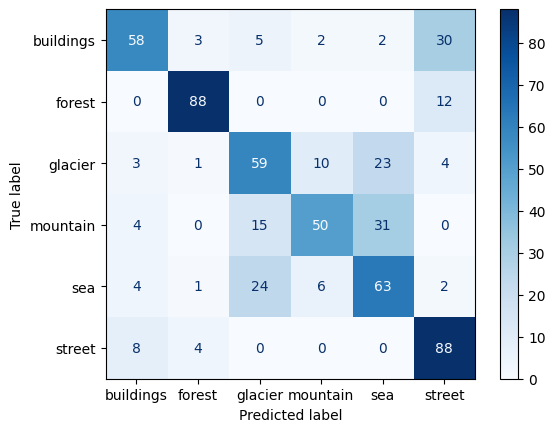

In [13]:
# Dictionary to convert labels from int to str
label_dict = {0:"buildings", 1:"forest", 2:"glacier", 3:"mountain",
          4:"sea", 5:"street"}

# Load the last model
last_model = keras.models.load_model("Simple_CNN_W_DepthP_at_20.h5")

# Generate predictions and true values
preds_lst = []
true_lst = []
for image in val_ds:
    prediction = np.argmax(last_model.predict(image[0]), axis=-1)
    prediction = np.array(prediction).tolist()
    preds_lst = preds_lst + prediction

    true_label = image[1]
    true_label = np.array(true_label).tolist()
    true_lst = true_lst + true_label


# Mapping labels
preds_lst = list(map(label_dict.get, preds_lst))
true_lst = list(map(label_dict.get, true_lst))


# Generate confusion matrix
ConfusionMatrixDisplay.from_predictions(true_lst, preds_lst, cmap="Blues")
plt.show()

In [14]:
# Calculate accuracy of Model 2
total_test = len(true_lst)
corr_preds = 0
for index, value in enumerate(true_lst):
    if value == preds_lst[index]:
        corr_preds += 1
        
acc = corr_preds / total_test * 100
print(f"Model Accuracy : {round(acc,2)}%")

Model Accuracy : 67.67%
